# Set up Environment

In [1]:
# Activate Virtual Environment and Install Requirements
!python3 -m venv ../fsl_env
!source ../fsl_env/bin/activate
!python3 -m ipykernel install --user --name=fsl_env --display-name "Python (fsl_env)"
#remember to switch to notebook/virtual environment kernel

Installed kernelspec fsl_env in /home/ejh2wy/.local/share/jupyter/kernels/fsl_env


!pip install -r requirements.txt # install requirements text in new environment
#!jupyter kernelspec uninstall fsl_env

In [3]:
# Import Packages
import os
from pathlib import Path
import re
import glob

import numpy as np
import pandas as pd
import matplotlib

import shutil
import itertools

import nilearn
from nilearn.image import load_img
from nilearn.image import math_img
from nilearn import plotting, datasets

import nibabel as nib
import nibabel.processing

#!pip install fslpy
import fsl
from fsl.wrappers import bet
import subprocess


# EDA

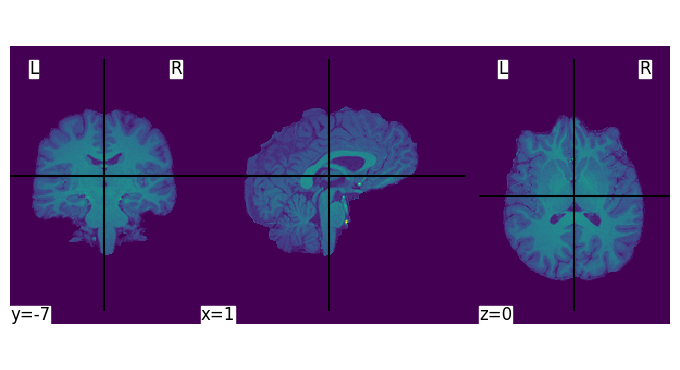

In [3]:
# Paths

# Preprocessed Image
#image_path = 'Original_Data/ABIDE1/CALTECH/sub-0051456/anat/sub-0051456_T1w.nii.gz'
#image_path = 'Original_Data/ABIDE2/ABIDEII-BNI_1/sub-29006/ses-1/anat/sub-29006_ses-1_run-1_T1w.nii.gz'
#image_path = 'Original_Data/ACE/sub-HAR30003/anat/sub-HAR30003_T1w.nii.gz'
#image_path = 'JustBrain_Data/ABIDE2/sub-28675/anat/sub-28675_T1w.nii.gz'
image_path = 'JustBrain_Data/ABIDE1/sub-0050002/anat/sub-0050002_T1w.nii.gz'

# Load Image
img = nilearn.image.load_img(image_path)

# Plot
plotting.plot_img(image_path)

In [4]:
print(img.get_fdata().shape)
print(img.header)

(176, 256, 256)
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 176 256 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.    1.    1.    1.    1.59  0.    0.    0.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FSL4.1'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 88.855934
qoffset_y       : -55.81357
qoffset_z       : -

# Create TSV Files and Summary Tables

## ABIDEII

In [5]:
# Took out UCLA because not in Garcia paper (and UCLA in ABIDEI)

Stucture your data following the BIDS organization (https://bids.neuroimaging.io/). Your participants.tsv file should contain:

1. a column called participant_id corresponding to the subject id (the same as the folder names in the BIDS dataset: sub-<participant_id>).
2. a column called label corresponding to the binary target variable (here: 0=no diagnosis, 1=Autism)
3. a column called dataset corresponding to where (training, validation, testing set) each participant data will be used: the code supports the three modalities train, val, test.

In [6]:
#### Participant TSV File ####

# Load metadata file
participants = pd.read_csv('Original_Data/Metadata/ABIDEII_Composite_Phenotypic.csv')

# Remove UCLA
participants = participants[participants['SITE_ID'] != 'ABIDEII-UCLA_1']

# Subset columns needed
participants = participants[["SUB_ID", "DX_GROUP", "SITE_ID"]]

# Change labels: 1 -> 1 (Autism), 2 -> 0 (non-Autism)
participants["DX_GROUP"] = participants["DX_GROUP"].replace({2: 0})

# Train/test split using vectorized operations
participants["dataset"] = "train"
participants.loc[
    participants["SITE_ID"].isin(["ABIDEII-EMC_1", "ABIDEII-UCD_1"]),
    "dataset",
] = "test"

#Split train into train and val (15% val)
train_indices = participants[participants["dataset"] == "train"].index
val_sample = np.random.choice(train_indices, size=int(0.15 * len(train_indices)), replace=False)
participants.loc[val_sample, "dataset"] = "val"

# Rename columns to match
participants.rename(columns={"SUB_ID": "participant_id", "DX_GROUP": "label"}, inplace=True)

# Remove site id column
participants_tsv = participants.drop('SITE_ID', axis=1)

# Export participants.tsv file
participants_tsv.to_csv('Original_Data/Metadata/ABIDEII_participants.tsv', sep='\t', index=False)

In [7]:
#### Participant Summary Table ####

# Add total row to count all labels per site
participants_with_total = pd.concat([
    participants,
    participants.assign(label='total')
])

# Group and pivot
summary = (
    participants_with_total
    .groupby(['SITE_ID', 'label', 'dataset'])
    .size()
    .reset_index(name='count')
    .pivot_table(index=['SITE_ID', 'label'], columns='dataset', values='count', fill_value=0)
    .astype(int)
    .reset_index()
)

# Rename labels
label_mapping = {'total': 'Total', 1: 'Autism', 0: 'No Autism'}
summary["label"] = summary["label"].map(label_mapping)

# Reorder rows so "Total" comes first per SITE_ID
summary["label_order"] = summary["label"].map({'Total': 0, 'Autism': 1, 'No Autism': 2})
summary.sort_values(by=["SITE_ID", "label_order"], inplace=True)
summary.drop(columns="label_order", inplace=True)

# Hide repeated SITE_IDs for clarity
summary["SITE_ID"] = summary["SITE_ID"].mask(summary["SITE_ID"].duplicated(), "")

# Reorder columns
summary = summary[["SITE_ID", "label", "train", "val", "test"]]

# Export to CSV
summary.to_csv("Original_Data/Metadata/ABIDEII_Participant_Summary.csv", index=False)


#### Total Participants ####
print(participants.shape[0])

1082


## ACE

In [8]:
#### Participant TSV File ####

# Load metadata file
participants = pd.read_csv('Original_Data/Metadata/ACE_Composite_Phenotypic.csv')

# Subset columns needed
participants = participants[["Site ID", "Cohort", "site"]]

# Keep only the numeric part of Site ID
participants["Site ID"] = participants["Site ID"].astype(str).str.extract(r'(\d+)')

# Change labels: ASD -> 1 (Autism), CON & US -> 0 (non-Autism)
participants["Cohort"] = participants["Cohort"].replace({'CON': 0, 'US': 0, 'ASD': 1})

# Train/test split using vectorized operations
participants["dataset"] = "test"

# Rename columns to match
participants.rename(columns={"Site ID": "participant_id", "Cohort": "label"}, inplace=True)

# Remove site id column
participants_tsv = participants.drop('site', axis=1)

# Export participants.tsv file
participants_tsv.to_csv('Original_Data/Metadata/ACE_participants.tsv', sep='\t', index=False)

/tmp/ipykernel_838795/1886445191.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  participants["Cohort"] = participants["Cohort"].replace({'CON': 0, 'US': 0, 'ASD': 1})


In [9]:
#### Participant Summary Table ####

# Create label mapping
label_mapping = {1: 'Autism', 0: 'No Autism'}

# Count by site and label
label_counts = (
    participants
    .replace({'label': label_mapping})
    .groupby(['site', 'label'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Add total column per site
label_counts["Total"] = label_counts["Autism"] + label_counts["No Autism"]

# Reorder columns
summary = label_counts[["site", "Total", "Autism", "No Autism"]]

# Add total row
total_row = pd.DataFrame({
    "site": ["Total"],
    "Total": [summary["Total"].sum()],
    "Autism": [summary["Autism"].sum()],
    "No Autism": [summary["No Autism"].sum()]
})

# Append total row to summary
summary = pd.concat([summary, total_row], ignore_index=True)

# Export to CSV
summary.to_csv("Original_Data/Metadata/ACE_Participant_Summary.csv", index=False)

#### Total Participants ####
print(participants.shape[0])

523


## ABIDEI

In [10]:
#### Participant TSV File ####

# Load metadata file
participants = pd.read_csv('Original_Data/Metadata/ABIDEI_Composite_Phenotypic.csv')

# Subset columns needed
participants = participants[["SUB_ID", "DX_GROUP", "SITE_ID"]]

# Change labels: 1 -> 1 (Autism), 2 -> 0 (non-Autism)
participants["DX_GROUP"] = participants["DX_GROUP"].replace({2: 0})

# Train/test split using vectorized operations
participants["dataset"] = "train"
participants.loc[
    participants["SITE_ID"].isin(["LEUVEN_1"]),
    "dataset",
] = "test"

#Split train into train and val (15% val)
train_indices = participants[participants["dataset"] == "train"].index
val_sample = np.random.choice(train_indices, size=int(0.15 * len(train_indices)), replace=False)
participants.loc[val_sample, "dataset"] = "val"

# Rename columns to match
participants.rename(columns={"SUB_ID": "participant_id", "DX_GROUP": "label"}, inplace=True)

# Remove site id column
participants_tsv = participants.drop('SITE_ID', axis=1)

# Export participants.tsv file
participants_tsv.to_csv('Original_Data/Metadata/ABIDEI_participants.tsv', sep='\t', index=False)

In [11]:
#### Participant Summary Table ####

# Add total row to count all labels per site
participants_with_total = pd.concat([
    participants,
    participants.assign(label='total')
])

# Group and pivot
summary = (
    participants_with_total
    .groupby(['SITE_ID', 'label', 'dataset'])
    .size()
    .reset_index(name='count')
    .pivot_table(index=['SITE_ID', 'label'], columns='dataset', values='count', fill_value=0)
    .astype(int)
    .reset_index()
)

# Rename labels
label_mapping = {'total': 'Total', 1: 'Autism', 0: 'No Autism'}
summary["label"] = summary["label"].map(label_mapping)

# Reorder rows so "Total" comes first per SITE_ID
summary["label_order"] = summary["label"].map({'Total': 0, 'Autism': 1, 'No Autism': 2})
summary.sort_values(by=["SITE_ID", "label_order"], inplace=True)
summary.drop(columns="label_order", inplace=True)

# Hide repeated SITE_IDs for clarity
summary["SITE_ID"] = summary["SITE_ID"].mask(summary["SITE_ID"].duplicated(), "")

# Reorder columns
summary = summary[["SITE_ID", "label", "train", "val", "test"]]

# Export to CSV
summary.to_csv("Original_Data/Metadata/ABIDEI_Participant_Summary.csv", index=False)


#### Total Participants ####
print(participants.shape[0])

1112


# Move files to BIDS Structure Directories

## ABIDEII

In [ ]:
# Define the original root and new destination directory
root_dir = "Original_Data/ABIDE2"
new_root_dir = "Restructured_Data/ABIDE2"  # New directory to store the copied files
metadata_dir = "Original_Data/Metadata"

In [24]:
# Load original Metadata File
test = pd.read_csv(os.path.join(metadata_dir, "ABIDEII_Composite_Phenotypic.csv"))
test = test[test['SITE_ID'] != 'ABIDEII-UCLA_1'] #Remove UCLA
print(len(test)) #1082

1082


In [28]:
# Load original participants.tsv
test = pd.read_csv(os.path.join(metadata_dir, "ABIDEII_participants.tsv"), sep="\t", dtype=str)
print(len(test)) #1082 - good!

1082


In [3]:
# Find all *_T1w.nii.gz files in the original structure
t1w_files = glob.glob(os.path.join(root_dir, "ABIDEII-*/sub-*/ses-1/anat/*_T1w.nii.gz"), recursive=True)
print(len(t1w_files)) #1244 - multiple runs per session sometimes

1244


In [4]:
#### BIDS FOLDER STRUCTURE ####

# Process each file
for file_path in t1w_files:
    # Extract subject ID from the path
    parts = file_path.split(os.sep)
    sub_index = parts.index("ses-1") - 1  # Index of the subject folder
    subject_id = parts[sub_index]

    # Define new directory and filename
    new_subject_dir = os.path.join(new_root_dir, subject_id, "anat")
    new_filename = f"{subject_id}_T1w.nii.gz"
    new_file_path = os.path.join(new_subject_dir, new_filename)

    # Create directories if they don't exist
    os.makedirs(new_subject_dir, exist_ok=True)

    # Copy the file instead of moving
    shutil.copy2(file_path, new_file_path) #re-writing over previous runs if multiple run - so last run for each subject kept (theoretically)

print("Reorganization complete! Files copied to:", new_root_dir)
lst = os.listdir(new_root_dir) # your directory path
number_files = len(lst)
print(number_files) #1012 - only taking the first run so less overall images (plus 1 for metadata file)

Reorganization complete! Files copied to: Restructured_Data/ABIDE2
1013


In [5]:
# Clean up tsv file to only include subjects with existing images

# Load original participants.tsv
df_participants = pd.read_csv(os.path.join(metadata_dir, "ABIDEII_participants.tsv"), sep="\t", dtype=str)

# Prepare a list to hold valid rows
valid_rows = []

# Loop through the dataframe and check if the corresponding file exists
for i, row in df_participants.iterrows():
    subid = row['participant_id']

    file_path = os.path.join(new_root_dir, f"sub-{subid}", "anat", f"sub-{subid}_T1w.nii.gz")

    if os.path.isfile(file_path):
        valid_rows.append(row)

# Create cleaned DataFrame
df_cleaned = pd.DataFrame(valid_rows)

# Save to a new TSV file
df_cleaned.to_csv(os.path.join(new_root_dir, "ABIDEII_participants_processed.tsv"), sep="\t", index=False)

print(df_cleaned.shape[0]) #1011 - 1 image didn't exist

1011


## ACE

In [4]:
# Define the original root and new destination directory
root_dir = "Original_Data/ACE"
new_root_dir = "Restructured_Data/ACE"  # New directory to store the copied files
metadata_dir = "Original_Data/Metadata"

In [3]:
# Load original Metadata File
test = pd.read_csv(os.path.join(metadata_dir, "ACE_Composite_Phenotypic.csv"))
print(len(test)) #523

523


In [12]:
# Load original participants.tsv
test = pd.read_csv(os.path.join(metadata_dir, "ACE_participants.tsv"), sep="\t", dtype=str)
print(len(test)) #523 - good!

523


In [13]:
# Find all *_T1w.nii.gz files in the original structure
t1w_files = glob.glob(os.path.join(root_dir, "sub-*/anat/*_T1w.nii.gz"), recursive=True)
print(len(t1w_files)) #461 - less images than in metadata file

461


In [19]:
#### BIDS FOLDER STRUCTURE ####

# Process each file
for file_path in t1w_files:
    # Extract subject ID from the path
    parts = file_path.split(os.sep)
    sub_index = parts.index("anat") - 1  # Index of the subject folder
    subject_id = parts[sub_index]
    
    # Remove the Site Characters from the subject number
    subject_id = re.sub(r"[a-zA-Z]", "", subject_id)

    # Define new directory and filename
    new_subject_dir = os.path.join(new_root_dir, f"sub{subject_id}", "anat")
    new_filename = f"sub{subject_id}_T1w.nii.gz"
    new_file_path = os.path.join(new_subject_dir, new_filename)

    # Create directories if they don't exist
    os.makedirs(new_subject_dir, exist_ok=True)

    # Copy the file instead of moving
    shutil.copy2(file_path, new_file_path) #re-writing over previous runs if multiple run - so last run for each subject kept (theoretically)

print("Reorganization complete! Files copied to:", new_root_dir)
lst = os.listdir(new_root_dir) # your directory path
number_files = len(lst)
print(number_files) #422 - only taking the first run so less overall images

Reorganization complete! Files copied to: Restructured_Data/ACE
422


In [5]:
# Clean up tsv file to only include subjects with existing images

# Load original participants.tsv
df_participants = pd.read_csv(os.path.join(metadata_dir, "ACE_participants.tsv"), sep="\t", dtype=str)

# Prepare a list to hold valid rows
valid_rows = []

# Loop through the dataframe and check if the corresponding file exists
for i, row in df_participants.iterrows():
    subid = row['participant_id']

    file_path = os.path.join(new_root_dir, f"sub-{subid}", "anat", f"sub-{subid}_T1w.nii.gz")

    if os.path.isfile(file_path):
        valid_rows.append(row)

# Create cleaned DataFrame
df_cleaned = pd.DataFrame(valid_rows)

# Save to a new TSV file
df_cleaned.to_csv(os.path.join(new_root_dir, "ACE_participants_processed.tsv"), sep="\t", index=False)

print(df_cleaned.shape[0]) #407 Some of the subjects not in the original metadata file

407


## ABIDEI

In [2]:
# Define the original root and new destination directory
root_dir = "Original_Data/ABIDE1"
new_root_dir = "Restructured_Data/ABIDE1"  # New directory to store the copied files
metadata_dir = "Original_Data/Metadata"

In [3]:
# Load original Metadata File
test = pd.read_csv(os.path.join(metadata_dir, "ABIDEI_Composite_Phenotypic.csv"))
print(len(test)) #1112

1112


In [4]:
# Load original participants.tsv
test = pd.read_csv(os.path.join(metadata_dir, "ABIDEI_participants.tsv"), sep="\t", dtype=str)
print(len(test)) #1112 - good!

1112


In [5]:
# Define the original root and new destination directory
root_dir = "Original_Data/ABIDE1"
new_root_dir = "Restructured_Data/ABIDE1"  # New directory to store the copied files
metadata_dir = "Original_Data/Metadata"

# Find all *_T1w.nii.gz files in the original structure
t1w_files = glob.glob(os.path.join(root_dir, "*/sub-*/anat/*_T1w.nii.gz"), recursive=True)
print(len(t1w_files)) #1102 - less images than in metadata file

1102


In [6]:
#### BIDS FOLDER STRUCTURE ####

# Process each file
for file_path in t1w_files:
    # Extract subject ID from the path
    parts = file_path.split(os.sep)
    sub_index = parts.index("anat") - 1  # Index of the subject folder
    subject_id = parts[sub_index]

    # Define new directory and filename
    new_subject_dir = os.path.join(new_root_dir, subject_id, "anat")
    new_filename = f"{subject_id}_T1w.nii.gz"
    new_file_path = os.path.join(new_subject_dir, new_filename)

    # Create directories if they don't exist
    os.makedirs(new_subject_dir, exist_ok=True)

    # Copy the file instead of moving
    shutil.copy2(file_path, new_file_path) #re-writing over previous runs if multiple run - so last run for each subject kept (theoretically)

print("Reorganization complete! Files copied to:", new_root_dir)
lst = os.listdir(new_root_dir) # your directory path
number_files = len(lst)
print(number_files) # Same number copied over!

Reorganization complete! Files copied to: Restructured_Data/ABIDE1
1102


In [8]:
# Clean up tsv file to only include subjects with existing images

# Load original participants.tsv
df_participants = pd.read_csv(os.path.join(metadata_dir, "ABIDEI_participants.tsv"), sep="\t", dtype=str)
# Add 2 leading zeros
df_participants['participant_id'] = df_participants['participant_id'].astype(str).str.zfill(7)

# Prepare a list to hold valid rows
valid_rows = []

# Loop through the dataframe and check if the corresponding file exists
for i, row in df_participants.iterrows():
    subid = row['participant_id']

    file_path = os.path.join(new_root_dir, f"sub-{subid}", "anat", f"sub-{subid}_T1w.nii.gz")

    if os.path.isfile(file_path):
        valid_rows.append(row)

# Create cleaned DataFrame
df_cleaned = pd.DataFrame(valid_rows)

# Save to a new TSV file
df_cleaned.to_csv(os.path.join(new_root_dir, "ABIDEI_participants_processed.tsv"), sep="\t", index=False)

print(df_cleaned.shape[0]) # Same number!

1102


# Remove Non-Brain Tissue

https://fsl.fmrib.ox.ac.uk/fsl/docs/#/structural/bet
https://git.fmrib.ox.ac.uk/fsl/fslpy

https://fsl.fmrib.ox.ac.uk/fsl/docs/#/install/linux

In [19]:
print(os.environ.get("FSLDIR"))
os.environ['FSLDIR'] = '/home/ejh2wy/fsl'
os.environ['PATH'] += os.pathsep + os.path.join(os.environ['FSLDIR'], 'bin')
os.environ['FSLOUTPUTTYPE'] = 'NIFTI_GZ'  # or 'NIFTI' if you don't want .nii.gz files

In [8]:
def count_folders(path):
    folder_count = 0
    for item in os.listdir(path):
        if os.path.isdir(os.path.join(path, item)):
            folder_count += 1
    return folder_count

In [12]:
def count_files(directory_path):
    """Counts the number of files in a directory.

    Args:
        directory_path: The path to the directory.

    Returns:
        The number of files in the directory, or -1 if the directory does not exist.
    """
    if not os.path.exists(directory_path):
        return -1
    
    file_count = 0
    for item in os.listdir(directory_path):
        item_path = os.path.join(directory_path, item)
        if os.path.isfile(item_path):
            file_count += 1
    return file_count

## ABIDEII

In [ ]:
# Specify the input directory containing the NIfTI files
input_dir = "Restructured_Data/ABIDE2"

# Specify the output directory for the skull-stripped images
output_dir = "JustBrain_Data/ABIDE2"

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Find all *_T1w.nii.gz files in the original structure
t1w_files = glob.glob(os.path.join(input_dir, "sub-*/anat/*_T1w.nii.gz"), recursive=True)

# Loop through all files in the input directory
for filename in t1w_files:
    # Extract the relative path (sub-xxx/anat/xxx_T1w.nii.gz) from the absolute file path
    filename = re.match(r"^(?:[^\/]*\/){2}(.*)", filename).group(1)
    
    # Construct the full paths for the input and output files
    input_path = os.path.join(input_dir, filename)
    output_path = os.path.join(output_dir, filename)

    #print(f"Processing {input_path} -> {output_path}")
    if not os.path.isfile(output_path):
        # Create the output directory
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        # Run FSL BET
        subprocess.run(['bet', input_path, output_path])

    else:
        print(f"Skipping {input_path}, output already exists.")

print('Finished processing all files.')

In [6]:
num_folders = count_folders(output_dir)
print(f"The number of folders in '{output_dir}' is: {num_folders}") #- matches - good!

The number of folders in 'JustBrain_Data/ABIDE2' is: 1012


## ACE

In [7]:
# Specify the input directory containing the NIfTI files
input_dir = "Restructured_Data/ACE"

# Specify the output directory for the skull-stripped images
output_dir = "JustBrain_Data/ACE"

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Find all *_T1w.nii.gz files in the original structure
t1w_files = glob.glob(os.path.join(input_dir, "sub-*/anat/*_T1w.nii.gz"), recursive=True)

# Loop through all files in the input directory
for filename in t1w_files:
    # Extract the relative path (sub-xxx/anat/xxx_T1w.nii.gz) from the absolute file path
    filename = re.match(r"^(?:[^\/]*\/){2}(.*)", filename).group(1)
    
    # Construct the full paths for the input and output files
    input_path = os.path.join(input_dir, filename)
    output_path = os.path.join(output_dir, filename)

    #print(f"Processing {input_path} -> {output_path}")
    if not os.path.isfile(output_path):
        # Create the output directory
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        # Run FSL BET
        subprocess.run(['bet', input_path, output_path])

    else:
        print(f"Skipping {input_path}, output already exists.")

print('Finished processing all files.')

Finished processing all files.


In [8]:
num_folders = count_folders(output_dir)
print(f"The number of folders in '{output_dir}' is: {num_folders}") #- correct - some people just not in metadatafile

The number of folders in 'JustBrain_Data/ACE' is: 421


## ABIDEI

In [9]:
# Specify the input directory containing the NIfTI files
input_dir = "Restructured_Data/ABIDE1"

# Specify the output directory for the skull-stripped images
output_dir = "JustBrain_Data/ABIDE1"

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Find all *_T1w.nii.gz files in the original structure
t1w_files = glob.glob(os.path.join(input_dir, "sub-*/anat/*_T1w.nii.gz"), recursive=True)

# Loop through all files in the input directory
for filename in t1w_files:
    # Extract the relative path (sub-xxx/anat/xxx_T1w.nii.gz) from the absolute file path
    filename = re.match(r"^(?:[^\/]*\/){2}(.*)", filename).group(1)
    
    # Construct the full paths for the input and output files
    input_path = os.path.join(input_dir, filename)
    output_path = os.path.join(output_dir, filename)

    #print(f"Processing {input_path} -> {output_path}")
    if not os.path.isfile(output_path):
        # Create the output directory
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        # Run FSL BET
        subprocess.run(['bet', input_path, output_path])

    else:
        print(f"Skipping {input_path}, output already exists.")

print('Finished processing all files.')

Finished processing all files.


In [10]:
num_folders = count_folders(output_dir)
print(f"The number of folders in '{output_dir}' is: {num_folders}")  #- matches - good!

The number of folders in 'JustBrain_Data/ABIDE1' is: 1102


# Preprocessing Steps!!

Towards 3D Deep Learning for neuropsychiatry: predicting Autism diagnosis using an interpretable Deep Learning pipeline applied to minimally processed structural MRI data, Melanie Garcia, Clare Kelly. medRxiv 2022.10.18.22281196; doi: https://doi.org/10.1101/2022.10.18.22281196

Github: https://github.com/garciaml/Autism-3D-CNN-brain-sMRI?tab=readme-ov-file

In [6]:
# Activate Virtual Environment and Install Requirements
#!python3 -m venv ../pretrainedresnet2
!source ../pretrainedresnet2/bin/activate
#!python3 -m ipykernel install --user --name=pretrainedresnet2 --display-name "Python (pretrainedresnet2)"
#Switch to notebook/virtual environment kernel

Installed kernelspec pretrainedresnet2 in /home/ejh2wy/.local/share/jupyter/kernels/pretrainedresnet2


In [ ]:
# clone github repo from above
#!git clone https://github.com/garciaml/Autism-3D-CNN-brain-sMRI.git
#!pip install -r requirements.txt # install requirements text in new environment

# Install additional things needed
#!pip install "torchio>=0.19.0"
#!pip install monai
#!pip install tensorboard
#!pip install torchsummary
import pandas as pd

## ABIDEII

In [5]:
# Copy over reprocessed tsv
metadata_dir = "Original_Data/Metadata"
new_root_dir = "JustBrain_Data/ABIDE2"

# Clean up tsv file to only include subjects with existing images

# Load original participants.tsv
df_participants = pd.read_csv(os.path.join(metadata_dir, "ABIDEII_participants.tsv"), sep="\t", dtype=str)

# Prepare a list to hold valid rows
valid_rows = []

# Loop through the dataframe and check if the corresponding file exists
for i, row in df_participants.iterrows():
    subid = row['participant_id']

    file_path = os.path.join(new_root_dir, f"sub-{subid}", "anat", f"sub-{subid}_T1w.nii.gz")

    if os.path.isfile(file_path):
        valid_rows.append(row)

# Create cleaned DataFrame
df_cleaned = pd.DataFrame(valid_rows)

# Save to a new TSV file
df_cleaned.to_csv(os.path.join(new_root_dir, "participants.tsv"), sep="\t", index=False)

print(df_cleaned.shape[0])

1011


In [6]:
# Preprocessing
!python ../Autism-3D-CNN-brain-sMRI/preprocessing_bids.py 'JustBrain_Data/ABIDE2' 'Preprocessed_Data/ABIDE2'

Traceback (most recent call last):
  File "/sfs/gpfs/tardis/home/ejh2wy/CHMCorr_Autism_Research/../Autism-3D-CNN-brain-sMRI/preprocessing_bids.py", line 125, in <module>
    transformed_subject = transform(subject)
                          ^^^^^^^^^^^^^^^^^^
  File "/home/ejh2wy/.local/lib/python3.11/site-packages/torchio/transforms/transform.py", line 162, in __call__
    transformed = self.apply_transform(subject)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ejh2wy/.local/lib/python3.11/site-packages/torchio/transforms/augmentation/composition.py", line 55, in apply_transform
    subject = transform(subject)  # type: ignore[assignment]
              ^^^^^^^^^^^^^^^^^^
  File "/home/ejh2wy/.local/lib/python3.11/site-packages/torchio/transforms/transform.py", line 162, in __call__
    transformed = self.apply_transform(subject)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ejh2wy/.local/lib/python3.11/site-packages/torchio/transforms/preprocessing/spat

In [13]:
# Check all data moved over
test_folder = count_files("Preprocessed_Data/ABIDE2/test")
train_folder = count_files("Preprocessed_Data/ABIDE2/train")
val_folder = count_files("Preprocessed_Data/ABIDE2/val")
print(test_folder + train_folder + val_folder)

768


## ACE

In [ ]:
# Copy over reprocessed tsv
metadata_dir = "Original_Data/Metadata"
new_root_dir = "JustBrain_Data/ACE"

# Clean up tsv file to only include subjects with existing images

# Load original participants.tsv
df_participants = pd.read_csv(os.path.join(metadata_dir, "ACE_participants.tsv"), sep="\t", dtype=str)

# Prepare a list to hold valid rows
valid_rows = []

# Loop through the dataframe and check if the corresponding file exists
for i, row in df_participants.iterrows():
    subid = row['participant_id']

    file_path = os.path.join(new_root_dir, f"sub-{subid}", "anat", f"sub-{subid}_T1w.nii.gz")

    if os.path.isfile(file_path):
        valid_rows.append(row)

# Create cleaned DataFrame
df_cleaned = pd.DataFrame(valid_rows)

# Save to a new TSV file
df_cleaned.to_csv(os.path.join(new_root_dir, "participants.tsv"), sep="\t", index=False)

print(df_cleaned.shape[0]) #1011 - good!

In [ ]:
# Preprocessing
!python ../Autism-3D-CNN-brain-sMRI/preprocessing_bids.py 'JustBrain_Data/ACE' 'Preprocessed_Data/ACE'

## ABIDEI

In [ ]:
# Copy over reprocessed tsv
metadata_dir = "Original_Data/Metadata"
new_root_dir = "JustBrain_Data/ABIDE1"

# Clean up tsv file to only include subjects with existing images

# Load original participants.tsv
df_participants = pd.read_csv(os.path.join(metadata_dir, "ABIDEI_participants.tsv"), sep="\t", dtype=str)

# Prepare a list to hold valid rows
valid_rows = []

# Loop through the dataframe and check if the corresponding file exists
for i, row in df_participants.iterrows():
    subid = row['participant_id']

    file_path = os.path.join(new_root_dir, f"sub-{subid}", "anat", f"sub-{subid}_T1w.nii.gz")

    if os.path.isfile(file_path):
        valid_rows.append(row)

# Create cleaned DataFrame
df_cleaned = pd.DataFrame(valid_rows)

# Save to a new TSV file
df_cleaned.to_csv(os.path.join(new_root_dir, "participants.tsv"), sep="\t", index=False)

print(df_cleaned.shape[0])

In [ ]:
# Preprocessing
!python ../Autism-3D-CNN-brain-sMRI/preprocessing_bids.py 'JustBrain_Data/ABIDE1' 'Preprocessed_Data/ABIDE1'